<a href="https://colab.research.google.com/github/yingtongxiong/MLCnotebooks/blob/xytExercise/8_Computation_graph_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install mlc-ai-nightly-cu110 -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 238.8 MB 27 kB/s 


In [2]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax, topi
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [4]:
@tvm.script.ir_module
class MyModule:
  @R.function
  def main(x: Tensor((3, 4), "float32"), y: Tensor((3, 4), "float32")):
      with relax.dataflow():
          lv0 = relax.multiply(x, y)
          gv0 = relax.add(lv0, y)
          relax.output(gv0)
      return gv0

In [5]:
relax_func = MyModule["main"]

In [6]:
type(relax_func)

tvm.relax.expr.Function

In [7]:
relax_func.params

[relax.expr.Var(0x4947e00), relax.expr.Var(0x4947d00)]

In [8]:
func_body = relax_func.body
type(func_body)

tvm.relax.expr.SeqExpr

In [9]:
func_body.blocks

[relax.expr.DataflowBlock(0x4b33740)]

In [10]:
dataflow_block = func_body.blocks[0]

In [11]:
dataflow_block.bindings

[relax.expr.VarBinding(0x4aa9b00), relax.expr.VarBinding(0x4aa99b0)]

In [12]:
binding = dataflow_block.bindings[0]

In [13]:
binding.var

relax.expr.DataflowVar(0x4947bc0)

In [14]:
binding.value

CallNode(Op(relax.multiply), [relax.expr.Var(0x4947e00), relax.expr.Var(0x4947d00)], (nullptr), [])

In [15]:
@relax.expr_functor.mutator
class EwiseFMARewriter(relax.PyExprMutator):
  def visit_call_(self, call):
    call = self.visit_expr_post_order(call)
    add_op = tvm.ir.Op.get("relax.add")
    multiply_op = tvm.ir.Op.get("relax.multiply")
    ewise_fma_op = tvm.ir.Op.get("relax.ewise_fma")

    if call.op != add_op:
      return call
    
    value = self.lookup_binding(call.args[0])
    if not isinstance(value, relax.Call) or value.op != multiply_op:
      return call
    
    fma_call = relax.Call(
        ewise_fma_op, [value.args[0], value.args[1], call.args[1]], None, None
    )
    return fma_call

updated_fn = EwiseFMARewriter().visit_expr(MyModule["main"])
updated_fn.show()

In [16]:
relax.analysis.remove_all_unused(updated_fn).show()

In [17]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-10-17 07:37:57--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-10-17 07:37:57--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.006s  

2022-10-17 07:37:57 (70.4 MB/s) - ‘fasionmnist_mlp_params.p

In [18]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

In [25]:
def create_model():
    bb = relax.BlockBuilder()
    x = relax.Var("x", (1, 784), relax.DynTensorType(2, "float32"))
    w0 = relax.const(mlp_params["w0"], "float32")
    b0 = relax.const(mlp_params["b0"], "float32")
    w1 = relax.const(mlp_params["w1"], "float32")
    b1 = relax.const(mlp_params["b1"], "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit(relax.op.dense(x, w0))
            lv1 = bb.emit(relax.op.add(lv0, b0))
            lv2 = bb.emit(relax.op.relu(lv1))
            lv3 = bb.emit(relax.op.dense(lv2, w1))
            lv4 = bb.emit(relax.op.add(lv3, b1))
            gv = bb.emit_output(lv4)
        bb.emit_func_output(gv)

    return bb.get()

MLPModel = create_model()
MLPModel.show()

In [27]:
@relax.expr_functor.mutator
class DenseAddFusor(relax.PyExprMutator):
    def __init__(self, mod: IRModule) -> None:
        super().__init__()
        self.mod_ = mod
        # cache pre-defined ops
        self.add_op = tvm.ir.Op.get("relax.add")
        self.dense_op = tvm.ir.Op.get("relax.nn.dense")
        self.counter = 0

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            # avoid already fused primitive functions
            if "Primitive" in func.attrs.keys() and func.attrs["Primitive"] != 0:
                continue
            updated_func = self.visit_expr(func)
            updated_func = relax.analysis.remove_all_unused(updated_func)
            self.builder_.update_func(global_var, updated_func)

        return self.builder_.get()

    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        def match_call(node, op):
            if not isinstance(node, relax.Call):
                return False
            return node.op == op

        # pattern match dense => add
        if not match_call(call, self.add_op):
            return call

        value = self.lookup_binding(call.args[0])
        if value is None:
            return call

        if not match_call(value, self.dense_op):
            return call

        x = value.args[0]
        w = value.args[1]
        b = call.args[1]

        # construct a new fused primitive function
        param_x = relax.Var("x", x.shape_, x._checked_type_)
        param_w = relax.Var("w", w.shape_, w._checked_type_)
        param_b = relax.Var("b", b.shape_, b._checked_type_)

        bb = relax.BlockBuilder()

        fn_name = "fused_dense_add%d" % (self.counter)
        self.counter += 1
        with bb.function(fn_name, [param_x, param_w, param_b]):
            with bb.dataflow():
                lv0 = bb.emit(relax.op.nn.dense(param_x, param_w))
                gv = bb.emit_output(relax.op.add(lv0, param_b))
            bb.emit_func_output(gv)

        # Add Primitive attribute to the fused funtions
        fused_fn = bb.get()[fn_name].with_attr("Primitive", 1)
        global_var = self.builder_.add_func(fused_fn, fn_name)

        # construct call into the fused function
        return relax.Call(global_var, [x, w, b], None, None)

@tvm.ir.transform.module_pass(opt_level=2, name="DeseAddFuse")
class FuseDenseAddPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return DenseAddFusor(mod).transform()


MLPFused = FuseDenseAddPass()(MLPModel)
MLPFused.show()

In [23]:
type(MLPFused)

tvm.ir.module.IRModule

In [29]:
@relax.expr_functor.mutator
class LowerToTensorIR(relax.PyExprMutator):
    def __init__(self, mod: IRModule, op_map) -> None:
        super().__init__()
        self.mod_ = mod
        self.op_map = {
            tvm.ir.Op.get(k): v for k, v in op_map.items()
        }


    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        if call.op in self.op_map:
            return self.op_map[call.op](self.builder_, call)
        return call

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            updated_func = self.visit_expr(func)
            self.builder_.update_func(global_var, updated_func)

        return self.builder_.get()


def map_dense(bb, call):
    x, w = call.args
    return bb.call_te(topi.nn.dense, x, w)

def map_add(bb, call):
    a, b = call.args
    return bb.call_te(topi.add, a, b)

def map_relu(bb, call):
    return bb.call_te(topi.nn.relu, call.args[0])


op_map = {
  "relax.nn.dense": map_dense,
  "relax.add": map_add,
  "relax.nn.relu": map_relu
}

@tvm.ir.transform.module_pass(opt_level=0, name="LowerToTensorIR")
class LowerToTensorIRPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return LowerToTensorIR(mod, op_map).transform()


MLPModelTIR = LowerToTensorIRPass()(MLPFused)
MLPModelTIR.show()

In [30]:
MLPModelFinal = relax.transform.FuseTIR()(MLPModelTIR)
MLPModelFinal.show()

In [31]:
# Hide outputs
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



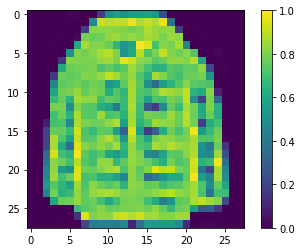

Class: Coat


In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [33]:
ex = relax.vm.build(MLPModelFinal, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Coat
